In [1]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

In [2]:
X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[:1617]
y = digits.target[:1617]

In [3]:
def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

In [4]:
def get_winner(class1):
    
    numbers = [*range(10)] # number 2 > number 1
    number_of_classification = len(numbers)
    #number_of_sampling = 100

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

        
    class2 = []

    class1_indexes = []
    class2_indexes = []

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("number of class1:{}".format(len(class1_label)))
    print("number of class2:{}".format(len(class2_label)))

    samplesize = 1617
    x_inputs =[tuple(c) for c in X[class1_indexes].tolist()] + [tuple(c) for c in X[class2_indexes].tolist()]
    x_outputs = [tuple([c]) for c in class1_label + class2_label]
    
    
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)

            outputs = []
            for xi in x_inputs:
                output = net.activate(xi)
                outputs.append(output)


            px_outputs = softmax(np.array(outputs).reshape(samplesize, 2), axis=1)
            # the index of maximum in each line
            pred_outputs = np.argmax(px_outputs, axis = 1)
            real_outputs = np.array(x_outputs).reshape(samplesize,)

            acc = np.sum(pred_outputs == real_outputs)/samplesize

            genome.fitness = acc

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, 150)

        return [stats, winner]
    
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-mnist2")
    [stats, winner] = run(config_path)
    
    return winner

In [5]:
import numpy as np
import random

number_codes = []
for i in range(2**(10-1), 2**10-1):
    for j in bin(i).split('b')[1]:
        number_codes.append(int(j))
number_codes = np.array(number_codes).reshape(2**9 - 1,10).T     

slice = random.sample(range(511),10)

number_codes = number_codes[:,slice].tolist() 

In [6]:
classes = []
for i in range(10):
    code_list = np.array(number_codes).T[i]
    classes.append(np.where(code_list==1)[0].tolist())

In [21]:
matrix_errors = []

for i in range(9):
    for j in range(i+1,10):
        matrix_errors.append(10 - np.sum(np.array(number_codes[i]) == np.array(number_codes[j])))
np.min(matrix_errors)
        # print(number_codes[i], number_codes[j], 3 - np.sum(np.array(number_codes[i]) == np.array(number_codes[j])))
#np.mean(matrix_errors)  

0

In [24]:
number_codes[1:-1]

[[0, 1, 0, 0, 1, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 1, 1, 0, 0, 0, 1, 1, 0],
 [0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
 [1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
 [1, 0, 1, 1, 0, 0, 0, 1, 1, 0],
 [1, 0, 1, 1, 0, 0, 1, 1, 0, 1]]

In [8]:
winner_list = []

for class1 in classes:
    winner = get_winner(class1)
    winner_list.append(winner)

number of class1:807
number of class2:810

 ****** Running generation 0 ****** 

Population's average fitness: 0.50483 stdev: 0.05060
Best fitness: 0.66048 - size: (2, 13) - species 1 - id 19
Average adjusted fitness: 0.123
Mean genetic distance 2.808, standard deviation 0.460
Population of 200 members in 20 species
Total extinctions: 0
Generation time: 8.774 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.52432 stdev: 0.05407
Best fitness: 0.71923 - size: (3, 15) - species 11 - id 303
Average adjusted fitness: 0.197
Mean genetic distance 2.943, standard deviation 0.490
Population of 199 members in 25 species
Total extinctions: 0
Generation time: 9.030 sec (8.902 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.54228 stdev: 0.05939
Best fitness: 0.71985 - size: (4, 16) - species 11 - id 543
Average adjusted fitness: 0.200
Mean genetic distance 3.041, standard deviation 0.499
Population of 201 members in 29 species
Total extincti

Population's average fitness: 0.60437 stdev: 0.07205
Best fitness: 0.72727 - size: (9, 24) - species 45 - id 3333
Average adjusted fitness: 0.186
Mean genetic distance 3.217, standard deviation 0.491
Population of 193 members in 35 species
Total extinctions: 0
Generation time: 19.743 sec (14.797 average)

 ****** Running generation 25 ****** 

Population's average fitness: 0.60536 stdev: 0.07165
Best fitness: 0.72727 - size: (9, 24) - species 35 - id 3333
Average adjusted fitness: 0.174
Mean genetic distance 3.221, standard deviation 0.498
Population of 194 members in 35 species
Total extinctions: 0
Generation time: 18.426 sec (15.372 average)

 ****** Running generation 26 ****** 

Population's average fitness: 0.59881 stdev: 0.07578
Best fitness: 0.72727 - size: (9, 24) - species 35 - id 3333
Average adjusted fitness: 0.186
Mean genetic distance 3.215, standard deviation 0.519
Population of 201 members in 33 species
Total extinctions: 0
Generation time: 21.103 sec (15.827 average)

 

Population's average fitness: 0.60865 stdev: 0.08719
Best fitness: 0.75943 - size: (7, 21) - species 19 - id 5848
Average adjusted fitness: 0.230
Mean genetic distance 3.376, standard deviation 0.543
Population of 203 members in 20 species
Total extinctions: 0
Generation time: 15.479 sec (15.091 average)

 ****** Running generation 49 ****** 

Population's average fitness: 0.60589 stdev: 0.08338
Best fitness: 0.75943 - size: (7, 21) - species 19 - id 5848
Average adjusted fitness: 0.188
Mean genetic distance 3.353, standard deviation 0.542
Population of 202 members in 20 species
Total extinctions: 0
Generation time: 16.055 sec (15.189 average)

 ****** Running generation 50 ****** 

Population's average fitness: 0.60655 stdev: 0.08107
Best fitness: 0.75943 - size: (7, 21) - species 19 - id 5848
Average adjusted fitness: 0.203
Mean genetic distance 3.371, standard deviation 0.544
Population of 196 members in 19 species
Total extinctions: 0
Generation time: 16.576 sec (15.353 average)

 

Population's average fitness: 0.60348 stdev: 0.08255
Best fitness: 0.77304 - size: (8, 27) - species 51 - id 7711
Average adjusted fitness: 0.300
Mean genetic distance 3.370, standard deviation 0.606
Population of 201 members in 15 species
Total extinctions: 0
Generation time: 17.597 sec (16.698 average)

 ****** Running generation 73 ****** 

Population's average fitness: 0.60869 stdev: 0.08167
Best fitness: 0.78293 - size: (9, 30) - species 51 - id 10784
Average adjusted fitness: 0.201
Mean genetic distance 3.346, standard deviation 0.639
Population of 200 members in 15 species
Total extinctions: 0
Generation time: 17.242 sec (16.808 average)

 ****** Running generation 74 ****** 

Population's average fitness: 0.60053 stdev: 0.08258
Best fitness: 0.78293 - size: (9, 30) - species 51 - id 10784
Average adjusted fitness: 0.187
Mean genetic distance 3.355, standard deviation 0.615
Population of 202 members in 15 species
Total extinctions: 0
Generation time: 17.606 sec (16.995 average)


Population's average fitness: 0.61739 stdev: 0.09387
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.249
Mean genetic distance 3.069, standard deviation 0.591
Population of 199 members in 15 species
Total extinctions: 0
Generation time: 18.302 sec (18.435 average)

 ****** Running generation 97 ****** 

Population's average fitness: 0.62031 stdev: 0.08949
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.209
Mean genetic distance 3.070, standard deviation 0.585
Population of 198 members in 15 species
Total extinctions: 0
Generation time: 18.712 sec (18.486 average)

 ****** Running generation 98 ****** 

Population's average fitness: 0.62636 stdev: 0.08792
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.170
Mean genetic distance 3.075, standard deviation 0.598
Population of 197 members in 15 species
Total extinctions: 0
Generation time: 19.014 sec (18.586 average)

Population's average fitness: 0.62170 stdev: 0.09937
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.267
Mean genetic distance 2.994, standard deviation 0.528
Population of 203 members in 16 species
Total extinctions: 0
Generation time: 19.214 sec (19.213 average)

 ****** Running generation 121 ****** 

Population's average fitness: 0.63435 stdev: 0.09090
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.280
Mean genetic distance 3.005, standard deviation 0.511
Population of 200 members in 16 species
Total extinctions: 0
Generation time: 19.340 sec (19.244 average)

 ****** Running generation 122 ****** 

Population's average fitness: 0.62605 stdev: 0.09510
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.274
Mean genetic distance 2.994, standard deviation 0.520
Population of 198 members in 16 species
Total extinctions: 0
Generation time: 19.066 sec (19.183 averag

Population's average fitness: 0.63523 stdev: 0.09425
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.316
Mean genetic distance 3.024, standard deviation 0.549
Population of 203 members in 14 species
Total extinctions: 0
Generation time: 19.240 sec (19.288 average)

 ****** Running generation 145 ****** 

Population's average fitness: 0.63577 stdev: 0.08917
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.239
Mean genetic distance 3.010, standard deviation 0.536
Population of 203 members in 14 species
Total extinctions: 0
Generation time: 19.634 sec (19.376 average)

 ****** Running generation 146 ****** 

Population's average fitness: 0.63899 stdev: 0.09583
Best fitness: 0.78479 - size: (8, 27) - species 51 - id 13754
Average adjusted fitness: 0.302
Mean genetic distance 3.042, standard deviation 0.523
Population of 203 members in 14 species
Total extinctions: 0
Generation time: 18.994 sec (19.376 averag

Population's average fitness: 0.63243 stdev: 0.10558
Best fitness: 0.79716 - size: (6, 22) - species 16 - id 2491
Average adjusted fitness: 0.296
Mean genetic distance 3.152, standard deviation 0.499
Population of 194 members in 36 species
Total extinctions: 0
Generation time: 13.220 sec (12.928 average)

 ****** Running generation 19 ****** 

Population's average fitness: 0.64784 stdev: 0.09828
Best fitness: 0.79716 - size: (6, 22) - species 16 - id 2491
Average adjusted fitness: 0.321
Mean genetic distance 3.174, standard deviation 0.485
Population of 203 members in 35 species
Total extinctions: 0
Generation time: 13.732 sec (12.999 average)

 ****** Running generation 20 ****** 

Population's average fitness: 0.63455 stdev: 0.10705
Best fitness: 0.79716 - size: (6, 22) - species 16 - id 2491
Average adjusted fitness: 0.304
Mean genetic distance 3.176, standard deviation 0.487
Population of 199 members in 35 species
Total extinctions: 0
Generation time: 13.765 sec (13.095 average)

 

Population's average fitness: 0.64859 stdev: 0.11484
Best fitness: 0.83921 - size: (8, 26) - species 35 - id 5309
Average adjusted fitness: 0.282
Mean genetic distance 3.335, standard deviation 0.550
Population of 193 members in 23 species
Total extinctions: 0
Generation time: 15.472 sec (15.576 average)

 ****** Running generation 43 ****** 

Population's average fitness: 0.66474 stdev: 0.10416
Best fitness: 0.83921 - size: (8, 26) - species 35 - id 5309
Average adjusted fitness: 0.256
Mean genetic distance 3.319, standard deviation 0.562
Population of 204 members in 21 species
Total extinctions: 0
Generation time: 15.311 sec (15.608 average)

 ****** Running generation 44 ****** 

Population's average fitness: 0.64817 stdev: 0.10535
Best fitness: 0.83921 - size: (8, 26) - species 35 - id 5309
Average adjusted fitness: 0.223
Mean genetic distance 3.307, standard deviation 0.557
Population of 200 members in 21 species
Total extinctions: 0
Generation time: 16.502 sec (15.720 average)

 

Population's average fitness: 0.67112 stdev: 0.11834
Best fitness: 0.84848 - size: (13, 36) - species 44 - id 8573
Average adjusted fitness: 0.266
Mean genetic distance 3.195, standard deviation 0.603
Population of 198 members in 14 species
Total extinctions: 0
Generation time: 18.584 sec (17.338 average)

 ****** Running generation 67 ****** 

Population's average fitness: 0.68419 stdev: 0.12106
Best fitness: 0.84848 - size: (13, 36) - species 44 - id 8573
Average adjusted fitness: 0.346
Mean genetic distance 3.222, standard deviation 0.603
Population of 199 members in 14 species
Total extinctions: 0
Generation time: 17.801 sec (17.428 average)

 ****** Running generation 68 ****** 

Population's average fitness: 0.67585 stdev: 0.11577
Best fitness: 0.84848 - size: (13, 36) - species 44 - id 8573
Average adjusted fitness: 0.271
Mean genetic distance 3.182, standard deviation 0.606
Population of 198 members in 16 species
Total extinctions: 0
Generation time: 18.415 sec (17.530 average)

Population's average fitness: 0.70581 stdev: 0.11081
Best fitness: 0.85158 - size: (14, 40) - species 49 - id 10883
Average adjusted fitness: 0.212
Mean genetic distance 3.181, standard deviation 0.552
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 20.329 sec (20.037 average)

 ****** Running generation 91 ****** 

Population's average fitness: 0.71318 stdev: 0.10844
Best fitness: 0.85158 - size: (14, 40) - species 49 - id 10883
Average adjusted fitness: 0.275
Mean genetic distance 3.172, standard deviation 0.533
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 20.472 sec (20.189 average)

 ****** Running generation 92 ****** 

Population's average fitness: 0.70660 stdev: 0.11867
Best fitness: 0.85158 - size: (14, 40) - species 49 - id 10883
Average adjusted fitness: 0.281
Mean genetic distance 3.139, standard deviation 0.540
Population of 201 members in 19 species
Total extinctions: 0
Generation time: 20.428 sec (20.208 avera

Population's average fitness: 0.70296 stdev: 0.11564
Best fitness: 0.85158 - size: (14, 40) - species 49 - id 10883
Average adjusted fitness: 0.233
Mean genetic distance 2.986, standard deviation 0.544
Population of 200 members in 12 species
Total extinctions: 0
Generation time: 21.406 sec (21.455 average)

 ****** Running generation 115 ****** 

Population's average fitness: 0.71430 stdev: 0.11303
Best fitness: 0.85158 - size: (14, 40) - species 49 - id 10883
Average adjusted fitness: 0.311
Mean genetic distance 2.986, standard deviation 0.549
Population of 203 members in 12 species
Total extinctions: 0
Generation time: 21.071 sec (21.463 average)

 ****** Running generation 116 ****** 

Population's average fitness: 0.69858 stdev: 0.12273
Best fitness: 0.85158 - size: (14, 40) - species 49 - id 10883
Average adjusted fitness: 0.326
Mean genetic distance 2.977, standard deviation 0.520
Population of 202 members in 12 species
Total extinctions: 0
Generation time: 20.887 sec (21.361 ave

Population's average fitness: 0.73926 stdev: 0.10855
Best fitness: 0.85591 - size: (21, 53) - species 73 - id 21830
Average adjusted fitness: 0.259
Mean genetic distance 3.086, standard deviation 0.568
Population of 199 members in 13 species
Total extinctions: 0
Generation time: 23.773 sec (22.295 average)

 ****** Running generation 139 ****** 

Population's average fitness: 0.71215 stdev: 0.12146
Best fitness: 0.85591 - size: (21, 53) - species 73 - id 21830
Average adjusted fitness: 0.247
Mean genetic distance 3.082, standard deviation 0.565
Population of 204 members in 12 species
Total extinctions: 0
Generation time: 22.949 sec (22.471 average)

 ****** Running generation 140 ****** 

Population's average fitness: 0.73039 stdev: 0.10707
Best fitness: 0.85591 - size: (21, 53) - species 73 - id 21830
Average adjusted fitness: 0.275
Mean genetic distance 3.072, standard deviation 0.559
Population of 202 members in 12 species
Total extinctions: 0
Generation time: 23.415 sec (22.627 ave

Population's average fitness: 0.65312 stdev: 0.13794
Best fitness: 0.81818 - size: (8, 24) - species 35 - id 1484
Average adjusted fitness: 0.364
Mean genetic distance 3.051, standard deviation 0.482
Population of 202 members in 45 species
Total extinctions: 0
Generation time: 12.525 sec (12.212 average)

 ****** Running generation 13 ****** 

Population's average fitness: 0.65810 stdev: 0.13317
Best fitness: 0.81818 - size: (8, 24) - species 35 - id 1484
Average adjusted fitness: 0.360
Mean genetic distance 3.076, standard deviation 0.478
Population of 204 members in 45 species
Total extinctions: 0
Generation time: 12.603 sec (12.336 average)

 ****** Running generation 14 ****** 

Population's average fitness: 0.64817 stdev: 0.14791
Best fitness: 0.81818 - size: (8, 24) - species 35 - id 1484
Average adjusted fitness: 0.389
Mean genetic distance 3.100, standard deviation 0.485
Population of 209 members in 45 species
Total extinctions: 0
Generation time: 12.834 sec (12.369 average)

 

Population's average fitness: 0.66845 stdev: 0.14081
Best fitness: 0.83302 - size: (7, 22) - species 39 - id 4611
Average adjusted fitness: 0.375
Mean genetic distance 3.249, standard deviation 0.531
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 14.632 sec (13.781 average)

 ****** Running generation 37 ****** 

Population's average fitness: 0.67662 stdev: 0.13687
Best fitness: 0.83859 - size: (8, 25) - species 48 - id 4925
Average adjusted fitness: 0.423
Mean genetic distance 3.277, standard deviation 0.528
Population of 202 members in 28 species
Total extinctions: 0
Generation time: 14.179 sec (13.885 average)

 ****** Running generation 38 ****** 

Population's average fitness: 0.67654 stdev: 0.13789
Best fitness: 0.83921 - size: (8, 25) - species 39 - id 5072
Average adjusted fitness: 0.392
Mean genetic distance 3.244, standard deviation 0.529
Population of 196 members in 27 species
Total extinctions: 0
Generation time: 14.589 sec (13.963 average)

 

Population's average fitness: 0.63898 stdev: 0.16291
Best fitness: 0.83921 - size: (8, 25) - species 39 - id 5072
Average adjusted fitness: 0.358
Mean genetic distance 3.361, standard deviation 0.583
Population of 205 members in 16 species
Total extinctions: 0
Generation time: 15.541 sec (15.618 average)

 ****** Running generation 61 ****** 

Population's average fitness: 0.65630 stdev: 0.14959
Best fitness: 0.83921 - size: (8, 25) - species 39 - id 5072
Average adjusted fitness: 0.361
Mean genetic distance 3.388, standard deviation 0.588
Population of 202 members in 15 species
Total extinctions: 0
Generation time: 16.168 sec (15.680 average)

 ****** Running generation 62 ****** 

Population's average fitness: 0.65136 stdev: 0.15660
Best fitness: 0.83921 - size: (8, 25) - species 39 - id 5072
Average adjusted fitness: 0.379
Mean genetic distance 3.408, standard deviation 0.583
Population of 199 members in 15 species
Total extinctions: 0
Generation time: 15.312 sec (15.693 average)

 

Population's average fitness: 0.66166 stdev: 0.16759
Best fitness: 0.84230 - size: (9, 26) - species 48 - id 10346
Average adjusted fitness: 0.365
Mean genetic distance 3.302, standard deviation 0.585
Population of 201 members in 18 species
Total extinctions: 0
Generation time: 17.292 sec (16.882 average)

 ****** Running generation 85 ****** 

Population's average fitness: 0.65600 stdev: 0.16446
Best fitness: 0.84230 - size: (9, 26) - species 48 - id 10346
Average adjusted fitness: 0.360
Mean genetic distance 3.298, standard deviation 0.578
Population of 201 members in 19 species
Total extinctions: 0
Generation time: 17.745 sec (17.000 average)

 ****** Running generation 86 ****** 

Population's average fitness: 0.67439 stdev: 0.15104
Best fitness: 0.84230 - size: (9, 26) - species 48 - id 10346
Average adjusted fitness: 0.370
Mean genetic distance 3.272, standard deviation 0.592
Population of 204 members in 16 species
Total extinctions: 0
Generation time: 19.026 sec (17.280 average)

Population's average fitness: 0.68188 stdev: 0.15675
Best fitness: 0.84910 - size: (16, 42) - species 77 - id 15998
Average adjusted fitness: 0.381
Mean genetic distance 3.251, standard deviation 0.609
Population of 194 members in 19 species
Total extinctions: 0
Generation time: 19.280 sec (19.766 average)

 ****** Running generation 109 ****** 

Population's average fitness: 0.70205 stdev: 0.15033
Best fitness: 0.85467 - size: (16, 40) - species 77 - id 16655
Average adjusted fitness: 0.385
Mean genetic distance 3.277, standard deviation 0.604
Population of 198 members in 20 species
Total extinctions: 0
Generation time: 18.098 sec (19.600 average)

 ****** Running generation 110 ****** 

Population's average fitness: 0.66756 stdev: 0.16695
Best fitness: 0.85467 - size: (16, 40) - species 77 - id 16655
Average adjusted fitness: 0.375
Mean genetic distance 3.289, standard deviation 0.604
Population of 204 members in 18 species
Total extinctions: 0
Generation time: 18.668 sec (19.483 ave

Population's average fitness: 0.65204 stdev: 0.16366
Best fitness: 0.86085 - size: (12, 35) - species 63 - id 20140
Average adjusted fitness: 0.360
Mean genetic distance 3.199, standard deviation 0.610
Population of 204 members in 14 species
Total extinctions: 0
Generation time: 19.620 sec (19.385 average)

 ****** Running generation 133 ****** 

Population's average fitness: 0.67538 stdev: 0.14386
Best fitness: 0.86085 - size: (12, 35) - species 63 - id 20140
Average adjusted fitness: 0.386
Mean genetic distance 3.192, standard deviation 0.611
Population of 203 members in 14 species
Total extinctions: 0
Generation time: 22.244 sec (19.720 average)

 ****** Running generation 134 ****** 

Population's average fitness: 0.65976 stdev: 0.16399
Best fitness: 0.86085 - size: (12, 35) - species 63 - id 20140
Average adjusted fitness: 0.362
Mean genetic distance 3.179, standard deviation 0.637
Population of 196 members in 14 species
Total extinctions: 0
Generation time: 21.062 sec (19.876 ave

Population's average fitness: 0.58534 stdev: 0.10619
Best fitness: 0.75510 - size: (4, 16) - species 16 - id 800
Average adjusted fitness: 0.229
Mean genetic distance 3.041, standard deviation 0.495
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 12.055 sec (11.080 average)

 ****** Running generation 7 ****** 

Population's average fitness: 0.59261 stdev: 0.10519
Best fitness: 0.77427 - size: (5, 18) - species 16 - id 1265
Average adjusted fitness: 0.285
Mean genetic distance 3.098, standard deviation 0.492
Population of 199 members in 33 species
Total extinctions: 0
Generation time: 12.226 sec (11.223 average)

 ****** Running generation 8 ****** 

Population's average fitness: 0.60954 stdev: 0.09524
Best fitness: 0.77427 - size: (5, 18) - species 16 - id 1265
Average adjusted fitness: 0.253
Mean genetic distance 3.098, standard deviation 0.496
Population of 197 members in 33 species
Total extinctions: 0
Generation time: 12.260 sec (11.338 average)

 ***

Population's average fitness: 0.63649 stdev: 0.11454
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.274
Mean genetic distance 3.245, standard deviation 0.501
Population of 196 members in 29 species
Total extinctions: 0
Generation time: 15.100 sec (14.368 average)

 ****** Running generation 31 ****** 

Population's average fitness: 0.63817 stdev: 0.11235
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.280
Mean genetic distance 3.241, standard deviation 0.526
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 14.633 sec (14.396 average)

 ****** Running generation 32 ****** 

Population's average fitness: 0.63986 stdev: 0.11388
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.264
Mean genetic distance 3.233, standard deviation 0.530
Population of 191 members in 28 species
Total extinctions: 0
Generation time: 14.552 sec (14.426 average)

Population's average fitness: 0.64789 stdev: 0.10268
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.265
Mean genetic distance 3.234, standard deviation 0.530
Population of 194 members in 20 species
Total extinctions: 0
Generation time: 16.705 sec (15.963 average)

 ****** Running generation 55 ****** 

Population's average fitness: 0.63507 stdev: 0.12273
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.244
Mean genetic distance 3.273, standard deviation 0.528
Population of 200 members in 20 species
Total extinctions: 0
Generation time: 16.364 sec (16.041 average)

 ****** Running generation 56 ****** 

Population's average fitness: 0.63151 stdev: 0.12515
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.357
Mean genetic distance 3.272, standard deviation 0.536
Population of 201 members in 20 species
Total extinctions: 0
Generation time: 16.892 sec (16.142 average)

Population's average fitness: 0.63490 stdev: 0.13099
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.362
Mean genetic distance 3.257, standard deviation 0.611
Population of 200 members in 11 species
Total extinctions: 0
Generation time: 18.475 sec (18.857 average)

 ****** Running generation 79 ****** 

Population's average fitness: 0.62102 stdev: 0.13374
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.281
Mean genetic distance 3.285, standard deviation 0.614
Population of 198 members in 11 species
Total extinctions: 0
Generation time: 19.070 sec (18.908 average)

 ****** Running generation 80 ****** 

Population's average fitness: 0.63147 stdev: 0.13275
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.321
Mean genetic distance 3.323, standard deviation 0.590
Population of 198 members in 13 species
Total extinctions: 0
Generation time: 18.841 sec (18.965 average)

Population's average fitness: 0.63436 stdev: 0.12735
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.325
Mean genetic distance 3.180, standard deviation 0.586
Population of 201 members in 12 species
Total extinctions: 0
Generation time: 20.040 sec (19.690 average)

 ****** Running generation 103 ****** 

Population's average fitness: 0.65897 stdev: 0.11106
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.267
Mean genetic distance 3.181, standard deviation 0.554
Population of 198 members in 14 species
Total extinctions: 0
Generation time: 20.237 sec (19.755 average)

 ****** Running generation 104 ****** 

Population's average fitness: 0.64656 stdev: 0.12152
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.254
Mean genetic distance 3.168, standard deviation 0.542
Population of 199 members in 15 species
Total extinctions: 0
Generation time: 21.837 sec (19.924 averag

Population's average fitness: 0.67640 stdev: 0.12093
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.276
Mean genetic distance 3.122, standard deviation 0.548
Population of 199 members in 16 species
Total extinctions: 0
Generation time: 20.945 sec (22.132 average)

 ****** Running generation 127 ****** 

Population's average fitness: 0.66882 stdev: 0.11915
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.276
Mean genetic distance 3.123, standard deviation 0.524
Population of 196 members in 16 species
Total extinctions: 0
Generation time: 21.572 sec (22.190 average)

 ****** Running generation 128 ****** 

Population's average fitness: 0.66219 stdev: 0.12847
Best fitness: 0.83241 - size: (10, 28) - species 31 - id 2724
Average adjusted fitness: 0.309
Mean genetic distance 3.110, standard deviation 0.528
Population of 202 members in 16 species
Total extinctions: 0
Generation time: 20.821 sec (22.025 averag

Population's average fitness: 0.49719 stdev: 0.05486
Best fitness: 0.65739 - size: (2, 13) - species 4 - id 121
Average adjusted fitness: 0.156
Mean genetic distance 2.856, standard deviation 0.444
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 8.205 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.52754 stdev: 0.06557
Best fitness: 0.72789 - size: (3, 15) - species 6 - id 297
Average adjusted fitness: 0.180
Mean genetic distance 2.950, standard deviation 0.469
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 8.549 sec (8.377 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.54967 stdev: 0.06944
Best fitness: 0.75015 - size: (2, 14) - species 2 - id 521
Average adjusted fitness: 0.135
Mean genetic distance 2.985, standard deviation 0.506
Population of 201 members in 27 species
Total extinctions: 0
Generation time: 8.876 sec (8.543 average)

 ****** Running generation 3 **

Population's average fitness: 0.62971 stdev: 0.09048
Best fitness: 0.80396 - size: (6, 19) - species 2 - id 3463
Average adjusted fitness: 0.287
Mean genetic distance 3.209, standard deviation 0.516
Population of 197 members in 28 species
Total extinctions: 0
Generation time: 11.308 sec (11.037 average)

 ****** Running generation 25 ****** 

Population's average fitness: 0.63049 stdev: 0.08684
Best fitness: 0.80396 - size: (6, 19) - species 2 - id 3463
Average adjusted fitness: 0.159
Mean genetic distance 3.194, standard deviation 0.519
Population of 195 members in 28 species
Total extinctions: 0
Generation time: 11.319 sec (11.099 average)

 ****** Running generation 26 ****** 

Population's average fitness: 0.63397 stdev: 0.08907
Best fitness: 0.80396 - size: (6, 19) - species 2 - id 3463
Average adjusted fitness: 0.205
Mean genetic distance 3.185, standard deviation 0.514
Population of 196 members in 27 species
Total extinctions: 0
Generation time: 12.640 sec (11.301 average)

 ***

Population's average fitness: 0.63140 stdev: 0.09769
Best fitness: 0.81509 - size: (6, 20) - species 2 - id 4890
Average adjusted fitness: 0.244
Mean genetic distance 3.134, standard deviation 0.560
Population of 196 members in 16 species
Total extinctions: 0
Generation time: 12.411 sec (11.956 average)

 ****** Running generation 49 ****** 

Population's average fitness: 0.63010 stdev: 0.10178
Best fitness: 0.81509 - size: (6, 20) - species 2 - id 4890
Average adjusted fitness: 0.226
Mean genetic distance 3.147, standard deviation 0.563
Population of 199 members in 16 species
Total extinctions: 0
Generation time: 11.819 sec (11.988 average)

 ****** Running generation 50 ****** 

Population's average fitness: 0.63404 stdev: 0.09462
Best fitness: 0.81509 - size: (6, 20) - species 2 - id 4890
Average adjusted fitness: 0.155
Mean genetic distance 3.154, standard deviation 0.582
Population of 200 members in 14 species
Total extinctions: 0
Generation time: 12.143 sec (11.986 average)

 ***

Population's average fitness: 0.64837 stdev: 0.10701
Best fitness: 0.82498 - size: (11, 30) - species 17 - id 10044
Average adjusted fitness: 0.222
Mean genetic distance 3.128, standard deviation 0.552
Population of 194 members in 18 species
Total extinctions: 0
Generation time: 13.318 sec (12.848 average)

 ****** Running generation 73 ****** 

Population's average fitness: 0.66121 stdev: 0.10525
Best fitness: 0.82498 - size: (11, 30) - species 17 - id 10044
Average adjusted fitness: 0.313
Mean genetic distance 3.135, standard deviation 0.549
Population of 200 members in 18 species
Total extinctions: 0
Generation time: 13.077 sec (12.904 average)

 ****** Running generation 74 ****** 

Population's average fitness: 0.66307 stdev: 0.10148
Best fitness: 0.82498 - size: (11, 30) - species 17 - id 10044
Average adjusted fitness: 0.240
Mean genetic distance 3.132, standard deviation 0.556
Population of 200 members in 15 species
Total extinctions: 0
Generation time: 12.992 sec (12.889 avera

Population's average fitness: 0.64913 stdev: 0.10701
Best fitness: 0.82498 - size: (11, 30) - species 17 - id 10044
Average adjusted fitness: 0.349
Mean genetic distance 3.272, standard deviation 0.558
Population of 203 members in 16 species
Total extinctions: 0
Generation time: 14.014 sec (13.472 average)

 ****** Running generation 97 ****** 

Population's average fitness: 0.63178 stdev: 0.10835
Best fitness: 0.82498 - size: (11, 30) - species 17 - id 10044
Average adjusted fitness: 0.254
Mean genetic distance 3.253, standard deviation 0.564
Population of 200 members in 16 species
Total extinctions: 0
Generation time: 14.538 sec (13.642 average)

 ****** Running generation 98 ****** 

Population's average fitness: 0.61778 stdev: 0.10903
Best fitness: 0.82498 - size: (11, 30) - species 17 - id 10044
Average adjusted fitness: 0.270
Mean genetic distance 3.243, standard deviation 0.587
Population of 195 members in 15 species
Total extinctions: 0
Generation time: 15.974 sec (13.910 avera

Population's average fitness: 0.65803 stdev: 0.11146
Best fitness: 0.82870 - size: (11, 29) - species 2 - id 15814
Average adjusted fitness: 0.303
Mean genetic distance 3.231, standard deviation 0.535
Population of 194 members in 17 species
Total extinctions: 0
Generation time: 16.558 sec (16.372 average)

 ****** Running generation 121 ****** 

Population's average fitness: 0.66393 stdev: 0.10322
Best fitness: 0.82870 - size: (11, 29) - species 2 - id 15814
Average adjusted fitness: 0.206
Mean genetic distance 3.225, standard deviation 0.530
Population of 195 members in 18 species
Total extinctions: 0
Generation time: 16.441 sec (16.490 average)

 ****** Running generation 122 ****** 

Population's average fitness: 0.64489 stdev: 0.11110
Best fitness: 0.82870 - size: (11, 29) - species 2 - id 15814
Average adjusted fitness: 0.249
Mean genetic distance 3.205, standard deviation 0.561
Population of 196 members in 17 species
Total extinctions: 0
Generation time: 16.323 sec (16.494 averag

Population's average fitness: 0.64020 stdev: 0.12017
Best fitness: 0.83488 - size: (13, 37) - species 82 - id 20764
Average adjusted fitness: 0.242
Mean genetic distance 3.143, standard deviation 0.559
Population of 201 members in 13 species
Total extinctions: 0
Generation time: 18.137 sec (18.617 average)

 ****** Running generation 145 ****** 

Population's average fitness: 0.64477 stdev: 0.11278
Best fitness: 0.83488 - size: (13, 37) - species 82 - id 20764
Average adjusted fitness: 0.208
Mean genetic distance 3.158, standard deviation 0.571
Population of 201 members in 14 species
Total extinctions: 0
Generation time: 18.321 sec (18.604 average)

 ****** Running generation 146 ****** 

Population's average fitness: 0.64727 stdev: 0.11978
Best fitness: 0.83488 - size: (13, 37) - species 82 - id 20764
Average adjusted fitness: 0.372
Mean genetic distance 3.173, standard deviation 0.565
Population of 197 members in 15 species
Total extinctions: 0
Generation time: 18.947 sec (18.653 ave

Population's average fitness: 0.82215 stdev: 0.20270
Best fitness: 0.98949 - size: (7, 22) - species 13 - id 2351
Average adjusted fitness: 0.718
Mean genetic distance 3.119, standard deviation 0.541
Population of 198 members in 25 species
Total extinctions: 0
Generation time: 10.727 sec (10.181 average)

 ****** Running generation 19 ****** 

Population's average fitness: 0.84428 stdev: 0.16370
Best fitness: 0.98949 - size: (7, 22) - species 13 - id 2351
Average adjusted fitness: 0.741
Mean genetic distance 3.094, standard deviation 0.547
Population of 197 members in 23 species
Total extinctions: 0
Generation time: 10.129 sec (10.208 average)

 ****** Running generation 20 ****** 

Population's average fitness: 0.84527 stdev: 0.17279
Best fitness: 0.98949 - size: (7, 22) - species 13 - id 2351
Average adjusted fitness: 0.742
Mean genetic distance 3.086, standard deviation 0.539
Population of 193 members in 24 species
Total extinctions: 0
Generation time: 10.507 sec (10.268 average)

 

Population's average fitness: 0.87485 stdev: 0.15458
Best fitness: 0.99134 - size: (7, 22) - species 13 - id 5829
Average adjusted fitness: 0.750
Mean genetic distance 3.207, standard deviation 0.526
Population of 199 members in 24 species
Total extinctions: 0
Generation time: 11.448 sec (11.451 average)

 ****** Running generation 43 ****** 

Population's average fitness: 0.84612 stdev: 0.19759
Best fitness: 0.99134 - size: (7, 22) - species 13 - id 5829
Average adjusted fitness: 0.726
Mean genetic distance 3.190, standard deviation 0.530
Population of 204 members in 24 species
Total extinctions: 0
Generation time: 11.734 sec (11.487 average)

 ****** Running generation 44 ****** 

Population's average fitness: 0.86222 stdev: 0.19122
Best fitness: 0.99134 - size: (7, 22) - species 13 - id 5829
Average adjusted fitness: 0.742
Mean genetic distance 3.198, standard deviation 0.524
Population of 201 members in 24 species
Total extinctions: 0
Generation time: 12.392 sec (11.549 average)

 

Population's average fitness: 0.88199 stdev: 0.16530
Best fitness: 0.99196 - size: (8, 22) - species 13 - id 8179
Average adjusted fitness: 0.762
Mean genetic distance 3.256, standard deviation 0.561
Population of 197 members in 18 species
Total extinctions: 0
Generation time: 13.730 sec (13.397 average)

 ****** Running generation 67 ****** 

Population's average fitness: 0.88402 stdev: 0.14925
Best fitness: 0.99196 - size: (8, 22) - species 13 - id 8179
Average adjusted fitness: 0.779
Mean genetic distance 3.257, standard deviation 0.573
Population of 197 members in 18 species
Total extinctions: 0
Generation time: 14.277 sec (13.570 average)

 ****** Running generation 68 ****** 

Population's average fitness: 0.89427 stdev: 0.11883
Best fitness: 0.99196 - size: (8, 22) - species 13 - id 8179
Average adjusted fitness: 0.783
Mean genetic distance 3.255, standard deviation 0.579
Population of 196 members in 18 species
Total extinctions: 0
Generation time: 14.444 sec (13.649 average)

 

Population's average fitness: 0.88764 stdev: 0.15567
Best fitness: 0.99382 - size: (13, 37) - species 68 - id 12524
Average adjusted fitness: 0.791
Mean genetic distance 3.331, standard deviation 0.630
Population of 205 members in 15 species
Total extinctions: 0
Generation time: 16.301 sec (15.719 average)

 ****** Running generation 91 ****** 

Population's average fitness: 0.87213 stdev: 0.16825
Best fitness: 0.99382 - size: (13, 37) - species 68 - id 12524
Average adjusted fitness: 0.765
Mean genetic distance 3.301, standard deviation 0.629
Population of 202 members in 14 species
Total extinctions: 0
Generation time: 16.815 sec (15.904 average)

 ****** Running generation 92 ****** 

Population's average fitness: 0.86929 stdev: 0.17804
Best fitness: 0.99382 - size: (13, 37) - species 68 - id 12524
Average adjusted fitness: 0.767
Mean genetic distance 3.291, standard deviation 0.638
Population of 202 members in 13 species
Total extinctions: 0
Generation time: 16.902 sec (16.112 avera

Population's average fitness: 0.84160 stdev: 0.22705
Best fitness: 0.99382 - size: (13, 37) - species 68 - id 12524
Average adjusted fitness: 0.736
Mean genetic distance 3.135, standard deviation 0.653
Population of 202 members in 11 species
Total extinctions: 0
Generation time: 19.493 sec (19.403 average)

 ****** Running generation 115 ****** 

Population's average fitness: 0.86080 stdev: 0.19671
Best fitness: 0.99382 - size: (13, 37) - species 68 - id 12524
Average adjusted fitness: 0.749
Mean genetic distance 3.177, standard deviation 0.643
Population of 197 members in 12 species
Total extinctions: 0
Generation time: 20.173 sec (19.553 average)

 ****** Running generation 116 ****** 

Population's average fitness: 0.84782 stdev: 0.21023
Best fitness: 0.99382 - size: (13, 37) - species 68 - id 12524
Average adjusted fitness: 0.754
Mean genetic distance 3.184, standard deviation 0.625
Population of 195 members in 12 species
Total extinctions: 0
Generation time: 19.835 sec (19.619 ave

Population's average fitness: 0.85851 stdev: 0.18600
Best fitness: 0.99443 - size: (10, 27) - species 13 - id 20212
Average adjusted fitness: 0.770
Mean genetic distance 2.934, standard deviation 0.563
Population of 198 members in 11 species
Total extinctions: 0
Generation time: 21.006 sec (21.405 average)

 ****** Running generation 139 ****** 

Population's average fitness: 0.85710 stdev: 0.19327
Best fitness: 0.99443 - size: (10, 27) - species 13 - id 20212
Average adjusted fitness: 0.750
Mean genetic distance 2.929, standard deviation 0.546
Population of 199 members in 11 species
Total extinctions: 0
Generation time: 20.014 sec (21.219 average)

 ****** Running generation 140 ****** 

Population's average fitness: 0.84812 stdev: 0.21916
Best fitness: 0.99443 - size: (10, 27) - species 13 - id 20212
Average adjusted fitness: 0.743
Mean genetic distance 2.925, standard deviation 0.531
Population of 201 members in 11 species
Total extinctions: 0
Generation time: 21.408 sec (21.144 ave

Population's average fitness: 0.62452 stdev: 0.08708
Best fitness: 0.77675 - size: (4, 17) - species 27 - id 1287
Average adjusted fitness: 0.360
Mean genetic distance 3.276, standard deviation 0.446
Population of 203 members in 45 species
Total extinctions: 0
Generation time: 11.747 sec (10.066 average)

 ****** Running generation 13 ****** 

Population's average fitness: 0.62946 stdev: 0.08302
Best fitness: 0.77675 - size: (4, 17) - species 27 - id 1287
Average adjusted fitness: 0.246
Mean genetic distance 3.268, standard deviation 0.448
Population of 202 members in 46 species
Total extinctions: 0
Generation time: 10.632 sec (10.184 average)

 ****** Running generation 14 ****** 

Population's average fitness: 0.62865 stdev: 0.09209
Best fitness: 0.77922 - size: (5, 19) - species 27 - id 1961
Average adjusted fitness: 0.320
Mean genetic distance 3.278, standard deviation 0.449
Population of 199 members in 46 species
Total extinctions: 0
Generation time: 10.972 sec (10.342 average)

 

Population's average fitness: 0.66056 stdev: 0.09432
Best fitness: 0.79716 - size: (9, 23) - species 33 - id 3926
Average adjusted fitness: 0.302
Mean genetic distance 3.272, standard deviation 0.502
Population of 192 members in 29 species
Total extinctions: 0
Generation time: 11.987 sec (11.558 average)

 ****** Running generation 37 ****** 

Population's average fitness: 0.66921 stdev: 0.07745
Best fitness: 0.79716 - size: (9, 23) - species 33 - id 3926
Average adjusted fitness: 0.270
Mean genetic distance 3.270, standard deviation 0.490
Population of 196 members in 29 species
Total extinctions: 0
Generation time: 12.750 sec (11.665 average)

 ****** Running generation 38 ****** 

Population's average fitness: 0.66170 stdev: 0.09089
Best fitness: 0.79716 - size: (9, 23) - species 33 - id 3926
Average adjusted fitness: 0.263
Mean genetic distance 3.270, standard deviation 0.493
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 12.963 sec (11.855 average)

 

Population's average fitness: 0.64496 stdev: 0.10895
Best fitness: 0.81633 - size: (12, 36) - species 11 - id 6599
Average adjusted fitness: 0.275
Mean genetic distance 3.252, standard deviation 0.562
Population of 193 members in 18 species
Total extinctions: 0
Generation time: 15.226 sec (14.079 average)

 ****** Running generation 61 ****** 

Population's average fitness: 0.66014 stdev: 0.10451
Best fitness: 0.81633 - size: (12, 36) - species 11 - id 6599
Average adjusted fitness: 0.265
Mean genetic distance 3.263, standard deviation 0.585
Population of 196 members in 18 species
Total extinctions: 0
Generation time: 13.730 sec (14.043 average)

 ****** Running generation 62 ****** 

Population's average fitness: 0.65167 stdev: 0.10828
Best fitness: 0.81633 - size: (12, 36) - species 11 - id 6599
Average adjusted fitness: 0.252
Mean genetic distance 3.304, standard deviation 0.590
Population of 196 members in 17 species
Total extinctions: 0
Generation time: 14.127 sec (14.060 average)

Population's average fitness: 0.67396 stdev: 0.11304
Best fitness: 0.85220 - size: (13, 34) - species 66 - id 9790
Average adjusted fitness: 0.422
Mean genetic distance 3.352, standard deviation 0.633
Population of 194 members in 16 species
Total extinctions: 0
Generation time: 16.825 sec (16.561 average)

 ****** Running generation 85 ****** 

Population's average fitness: 0.65972 stdev: 0.11641
Best fitness: 0.85220 - size: (13, 34) - species 66 - id 9790
Average adjusted fitness: 0.317
Mean genetic distance 3.332, standard deviation 0.628
Population of 198 members in 16 species
Total extinctions: 0
Generation time: 16.407 sec (16.631 average)

 ****** Running generation 86 ****** 

Population's average fitness: 0.68922 stdev: 0.09971
Best fitness: 0.85220 - size: (13, 34) - species 66 - id 9790
Average adjusted fitness: 0.332
Mean genetic distance 3.330, standard deviation 0.656
Population of 196 members in 15 species
Total extinctions: 0
Generation time: 16.802 sec (16.695 average)

Population's average fitness: 0.66728 stdev: 0.11306
Best fitness: 0.85220 - size: (13, 34) - species 66 - id 9790
Average adjusted fitness: 0.402
Mean genetic distance 3.188, standard deviation 0.596
Population of 198 members in 13 species
Total extinctions: 0
Generation time: 19.351 sec (18.787 average)

 ****** Running generation 109 ****** 

Population's average fitness: 0.66504 stdev: 0.10431
Best fitness: 0.85220 - size: (13, 34) - species 66 - id 9790
Average adjusted fitness: 0.329
Mean genetic distance 3.185, standard deviation 0.602
Population of 199 members in 13 species
Total extinctions: 0
Generation time: 19.012 sec (18.854 average)

 ****** Running generation 110 ****** 

Population's average fitness: 0.66977 stdev: 0.11364
Best fitness: 0.85220 - size: (13, 34) - species 66 - id 9790
Average adjusted fitness: 0.341
Mean genetic distance 3.197, standard deviation 0.585
Population of 197 members in 15 species
Total extinctions: 0
Generation time: 19.438 sec (18.935 averag

Population's average fitness: 0.67813 stdev: 0.10378
Best fitness: 0.85281 - size: (14, 36) - species 66 - id 18586
Average adjusted fitness: 0.345
Mean genetic distance 3.085, standard deviation 0.520
Population of 199 members in 15 species
Total extinctions: 0
Generation time: 21.323 sec (20.797 average)

 ****** Running generation 133 ****** 

Population's average fitness: 0.66934 stdev: 0.11434
Best fitness: 0.85281 - size: (14, 36) - species 66 - id 18586
Average adjusted fitness: 0.448
Mean genetic distance 3.074, standard deviation 0.542
Population of 197 members in 15 species
Total extinctions: 0
Generation time: 20.578 sec (20.839 average)

 ****** Running generation 134 ****** 

Population's average fitness: 0.68296 stdev: 0.10912
Best fitness: 0.85281 - size: (14, 36) - species 66 - id 18586
Average adjusted fitness: 0.422
Mean genetic distance 3.068, standard deviation 0.544
Population of 197 members in 15 species
Total extinctions: 0
Generation time: 20.680 sec (20.840 ave

Population's average fitness: 0.63727 stdev: 0.12662
Best fitness: 0.79468 - size: (4, 15) - species 22 - id 978
Average adjusted fitness: 0.362
Mean genetic distance 3.080, standard deviation 0.512
Population of 202 members in 32 species
Total extinctions: 0
Generation time: 10.054 sec (8.946 average)

 ****** Running generation 7 ****** 

Population's average fitness: 0.63013 stdev: 0.13365
Best fitness: 0.79468 - size: (4, 15) - species 22 - id 978
Average adjusted fitness: 0.353
Mean genetic distance 3.057, standard deviation 0.518
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 10.076 sec (9.087 average)

 ****** Running generation 8 ****** 

Population's average fitness: 0.62813 stdev: 0.13551
Best fitness: 0.79468 - size: (4, 15) - species 22 - id 978
Average adjusted fitness: 0.356
Mean genetic distance 3.046, standard deviation 0.508
Population of 200 members in 33 species
Total extinctions: 0
Generation time: 10.018 sec (9.191 average)

 ****** R

Population's average fitness: 0.65625 stdev: 0.13008
Best fitness: 0.79839 - size: (8, 22) - species 21 - id 3118
Average adjusted fitness: 0.360
Mean genetic distance 3.207, standard deviation 0.495
Population of 201 members in 32 species
Total extinctions: 0
Generation time: 11.842 sec (11.616 average)

 ****** Running generation 31 ****** 

Population's average fitness: 0.65398 stdev: 0.13292
Best fitness: 0.81200 - size: (8, 23) - species 21 - id 4495
Average adjusted fitness: 0.354
Mean genetic distance 3.226, standard deviation 0.508
Population of 202 members in 34 species
Total extinctions: 0
Generation time: 11.977 sec (11.647 average)

 ****** Running generation 32 ****** 

Population's average fitness: 0.65283 stdev: 0.13718
Best fitness: 0.81200 - size: (8, 23) - species 21 - id 4495
Average adjusted fitness: 0.380
Mean genetic distance 3.223, standard deviation 0.506
Population of 196 members in 33 species
Total extinctions: 0
Generation time: 12.291 sec (11.739 average)

 

Population's average fitness: 0.64891 stdev: 0.15344
Best fitness: 0.81447 - size: (9, 24) - species 21 - id 5577
Average adjusted fitness: 0.349
Mean genetic distance 3.265, standard deviation 0.575
Population of 199 members in 16 species
Total extinctions: 0
Generation time: 13.425 sec (13.587 average)

 ****** Running generation 55 ****** 

Population's average fitness: 0.65329 stdev: 0.13738
Best fitness: 0.82437 - size: (9, 24) - species 21 - id 8123
Average adjusted fitness: 0.350
Mean genetic distance 3.300, standard deviation 0.568
Population of 200 members in 17 species
Total extinctions: 0
Generation time: 13.956 sec (13.572 average)

 ****** Running generation 56 ****** 

Population's average fitness: 0.65261 stdev: 0.13854
Best fitness: 0.82437 - size: (7, 21) - species 47 - id 8268
Average adjusted fitness: 0.352
Mean genetic distance 3.292, standard deviation 0.566
Population of 199 members in 17 species
Total extinctions: 0
Generation time: 14.032 sec (13.662 average)

 

Population's average fitness: 0.67062 stdev: 0.13440
Best fitness: 0.83550 - size: (7, 21) - species 58 - id 11188
Average adjusted fitness: 0.372
Mean genetic distance 3.117, standard deviation 0.583
Population of 201 members in 17 species
Total extinctions: 0
Generation time: 14.347 sec (13.599 average)

 ****** Running generation 79 ****** 

Population's average fitness: 0.67790 stdev: 0.12411
Best fitness: 0.83550 - size: (7, 21) - species 58 - id 11188
Average adjusted fitness: 0.390
Mean genetic distance 3.093, standard deviation 0.573
Population of 204 members in 17 species
Total extinctions: 0
Generation time: 13.925 sec (13.677 average)

 ****** Running generation 80 ****** 

Population's average fitness: 0.66993 stdev: 0.13974
Best fitness: 0.83550 - size: (7, 21) - species 58 - id 11188
Average adjusted fitness: 0.365
Mean genetic distance 3.164, standard deviation 0.580
Population of 197 members in 18 species
Total extinctions: 0
Generation time: 14.144 sec (13.767 average)

Population's average fitness: 0.68463 stdev: 0.12022
Best fitness: 0.84725 - size: (9, 24) - species 67 - id 14992
Average adjusted fitness: 0.380
Mean genetic distance 3.141, standard deviation 0.609
Population of 195 members in 13 species
Total extinctions: 0
Generation time: 15.398 sec (15.336 average)

 ****** Running generation 103 ****** 

Population's average fitness: 0.66688 stdev: 0.13521
Best fitness: 0.85158 - size: (10, 27) - species 67 - id 16199
Average adjusted fitness: 0.373
Mean genetic distance 3.150, standard deviation 0.549
Population of 197 members in 16 species
Total extinctions: 0
Generation time: 14.705 sec (15.343 average)

 ****** Running generation 104 ****** 

Population's average fitness: 0.67192 stdev: 0.12975
Best fitness: 0.85158 - size: (10, 27) - species 67 - id 16199
Average adjusted fitness: 0.381
Mean genetic distance 3.150, standard deviation 0.577
Population of 203 members in 16 species
Total extinctions: 0
Generation time: 15.677 sec (15.382 aver

Population's average fitness: 0.68912 stdev: 0.12999
Best fitness: 0.85158 - size: (10, 27) - species 67 - id 16199
Average adjusted fitness: 0.380
Mean genetic distance 3.243, standard deviation 0.554
Population of 196 members in 21 species
Total extinctions: 0
Generation time: 16.611 sec (16.527 average)

 ****** Running generation 127 ****** 

Population's average fitness: 0.68535 stdev: 0.13361
Best fitness: 0.85220 - size: (13, 34) - species 71 - id 20264
Average adjusted fitness: 0.377
Mean genetic distance 3.251, standard deviation 0.580
Population of 193 members in 20 species
Total extinctions: 0
Generation time: 16.269 sec (16.580 average)

 ****** Running generation 128 ****** 

Population's average fitness: 0.68253 stdev: 0.13017
Best fitness: 0.85220 - size: (10, 27) - species 79 - id 20274
Average adjusted fitness: 0.379
Mean genetic distance 3.266, standard deviation 0.594
Population of 199 members in 20 species
Total extinctions: 0
Generation time: 16.037 sec (16.575 ave

Population's average fitness: 0.47801 stdev: 0.08638
Best fitness: 0.67038 - size: (2, 13) - species 1 - id 77
Average adjusted fitness: 0.172
Mean genetic distance 2.936, standard deviation 0.495
Population of 200 members in 27 species
Total extinctions: 0
Generation time: 7.969 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.53165 stdev: 0.09805
Best fitness: 0.78602 - size: (3, 15) - species 1 - id 335
Average adjusted fitness: 0.253
Mean genetic distance 3.040, standard deviation 0.488
Population of 200 members in 33 species
Total extinctions: 0
Generation time: 8.581 sec (8.275 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.56473 stdev: 0.10323
Best fitness: 0.80148 - size: (2, 14) - species 1 - id 539
Average adjusted fitness: 0.372
Mean genetic distance 3.103, standard deviation 0.494
Population of 203 members in 36 species
Total extinctions: 0
Generation time: 9.180 sec (8.577 average)

 ****** Running generation 3 ***

Population's average fitness: 0.65264 stdev: 0.11295
Best fitness: 0.84045 - size: (8, 25) - species 31 - id 3130
Average adjusted fitness: 0.300
Mean genetic distance 3.288, standard deviation 0.498
Population of 198 members in 41 species
Total extinctions: 0
Generation time: 11.751 sec (11.298 average)

 ****** Running generation 25 ****** 

Population's average fitness: 0.65780 stdev: 0.11024
Best fitness: 0.84045 - size: (8, 25) - species 31 - id 3130
Average adjusted fitness: 0.290
Mean genetic distance 3.317, standard deviation 0.497
Population of 196 members in 42 species
Total extinctions: 0
Generation time: 11.290 sec (11.149 average)

 ****** Running generation 26 ****** 

Population's average fitness: 0.65833 stdev: 0.10573
Best fitness: 0.84045 - size: (8, 25) - species 31 - id 3130
Average adjusted fitness: 0.339
Mean genetic distance 3.307, standard deviation 0.494
Population of 196 members in 38 species
Total extinctions: 0
Generation time: 11.048 sec (11.180 average)

 

Population's average fitness: 0.66137 stdev: 0.11539
Best fitness: 0.86889 - size: (10, 30) - species 31 - id 5965
Average adjusted fitness: 0.260
Mean genetic distance 3.364, standard deviation 0.533
Population of 194 members in 22 species
Total extinctions: 0
Generation time: 12.122 sec (12.250 average)

 ****** Running generation 49 ****** 

Population's average fitness: 0.65484 stdev: 0.11679
Best fitness: 0.86889 - size: (10, 30) - species 31 - id 5965
Average adjusted fitness: 0.316
Mean genetic distance 3.363, standard deviation 0.555
Population of 201 members in 22 species
Total extinctions: 0
Generation time: 12.443 sec (12.314 average)

 ****** Running generation 50 ****** 

Population's average fitness: 0.66411 stdev: 0.11165
Best fitness: 0.86889 - size: (10, 30) - species 31 - id 5965
Average adjusted fitness: 0.293
Mean genetic distance 3.347, standard deviation 0.548
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 13.107 sec (12.453 average)

Population's average fitness: 0.67404 stdev: 0.10969
Best fitness: 0.87137 - size: (12, 32) - species 31 - id 9872
Average adjusted fitness: 0.282
Mean genetic distance 3.362, standard deviation 0.592
Population of 204 members in 18 species
Total extinctions: 0
Generation time: 14.298 sec (13.795 average)

 ****** Running generation 73 ****** 

Population's average fitness: 0.68265 stdev: 0.10350
Best fitness: 0.87137 - size: (12, 32) - species 59 - id 9872
Average adjusted fitness: 0.284
Mean genetic distance 3.342, standard deviation 0.612
Population of 202 members in 18 species
Total extinctions: 0
Generation time: 14.635 sec (13.913 average)

 ****** Running generation 74 ****** 

Population's average fitness: 0.66966 stdev: 0.11948
Best fitness: 0.87137 - size: (12, 32) - species 59 - id 9872
Average adjusted fitness: 0.280
Mean genetic distance 3.328, standard deviation 0.618
Population of 204 members in 18 species
Total extinctions: 0
Generation time: 15.254 sec (14.039 average)

Population's average fitness: 0.67410 stdev: 0.11025
Best fitness: 0.88002 - size: (15, 37) - species 70 - id 11707
Average adjusted fitness: 0.279
Mean genetic distance 3.340, standard deviation 0.613
Population of 201 members in 20 species
Total extinctions: 0
Generation time: 16.989 sec (16.069 average)

 ****** Running generation 97 ****** 

Population's average fitness: 0.66510 stdev: 0.12493
Best fitness: 0.88002 - size: (15, 37) - species 70 - id 11707
Average adjusted fitness: 0.384
Mean genetic distance 3.347, standard deviation 0.617
Population of 193 members in 19 species
Total extinctions: 0
Generation time: 17.009 sec (16.159 average)

 ****** Running generation 98 ****** 

Population's average fitness: 0.65943 stdev: 0.12681
Best fitness: 0.88002 - size: (15, 37) - species 70 - id 11707
Average adjusted fitness: 0.305
Mean genetic distance 3.343, standard deviation 0.625
Population of 193 members in 18 species
Total extinctions: 0
Generation time: 16.090 sec (16.166 avera

Population's average fitness: 0.66592 stdev: 0.13800
Best fitness: 0.88559 - size: (17, 42) - species 63 - id 15360
Average adjusted fitness: 0.267
Mean genetic distance 3.251, standard deviation 0.593
Population of 201 members in 18 species
Total extinctions: 0
Generation time: 18.619 sec (18.344 average)

 ****** Running generation 121 ****** 

Population's average fitness: 0.65784 stdev: 0.13460
Best fitness: 0.88559 - size: (17, 42) - species 63 - id 15360
Average adjusted fitness: 0.265
Mean genetic distance 3.244, standard deviation 0.596
Population of 204 members in 18 species
Total extinctions: 0
Generation time: 18.020 sec (18.354 average)

 ****** Running generation 122 ****** 

Population's average fitness: 0.67209 stdev: 0.13420
Best fitness: 0.88559 - size: (17, 42) - species 63 - id 15360
Average adjusted fitness: 0.275
Mean genetic distance 3.242, standard deviation 0.604
Population of 205 members in 18 species
Total extinctions: 0
Generation time: 19.000 sec (18.485 ave

Population's average fitness: 0.67613 stdev: 0.12466
Best fitness: 0.88559 - size: (17, 42) - species 63 - id 15360
Average adjusted fitness: 0.295
Mean genetic distance 3.193, standard deviation 0.635
Population of 205 members in 14 species
Total extinctions: 0
Generation time: 19.032 sec (18.470 average)

 ****** Running generation 145 ****** 

Population's average fitness: 0.66922 stdev: 0.13197
Best fitness: 0.88559 - size: (17, 42) - species 63 - id 15360
Average adjusted fitness: 0.291
Mean genetic distance 3.221, standard deviation 0.618
Population of 204 members in 15 species
Total extinctions: 0
Generation time: 18.763 sec (18.464 average)

 ****** Running generation 146 ****** 

Population's average fitness: 0.66494 stdev: 0.13156
Best fitness: 0.88621 - size: (18, 44) - species 63 - id 22590
Average adjusted fitness: 0.298
Mean genetic distance 3.237, standard deviation 0.618
Population of 203 members in 15 species
Total extinctions: 0
Generation time: 19.420 sec (18.598 ave

Population's average fitness: 0.76587 stdev: 0.11271
Best fitness: 0.89054 - size: (7, 22) - species 18 - id 1885
Average adjusted fitness: 0.561
Mean genetic distance 3.028, standard deviation 0.518
Population of 197 members in 27 species
Total extinctions: 0
Generation time: 10.919 sec (10.299 average)

 ****** Running generation 19 ****** 

Population's average fitness: 0.74434 stdev: 0.14550
Best fitness: 0.89054 - size: (7, 22) - species 18 - id 1885
Average adjusted fitness: 0.547
Mean genetic distance 2.998, standard deviation 0.529
Population of 194 members in 25 species
Total extinctions: 0
Generation time: 10.702 sec (10.329 average)

 ****** Running generation 20 ****** 

Population's average fitness: 0.74707 stdev: 0.14335
Best fitness: 0.89116 - size: (4, 19) - species 13 - id 2926
Average adjusted fitness: 0.547
Mean genetic distance 3.033, standard deviation 0.533
Population of 198 members in 23 species
Total extinctions: 0
Generation time: 10.412 sec (10.331 average)

 

Population's average fitness: 0.74389 stdev: 0.15477
Best fitness: 0.89301 - size: (5, 18) - species 13 - id 6273
Average adjusted fitness: 0.540
Mean genetic distance 3.179, standard deviation 0.543
Population of 192 members in 21 species
Total extinctions: 0
Generation time: 13.120 sec (12.875 average)

 ****** Running generation 43 ****** 

Population's average fitness: 0.74397 stdev: 0.16085
Best fitness: 0.89301 - size: (5, 18) - species 13 - id 6273
Average adjusted fitness: 0.545
Mean genetic distance 3.193, standard deviation 0.551
Population of 197 members in 21 species
Total extinctions: 0
Generation time: 14.046 sec (13.080 average)

 ****** Running generation 44 ****** 

Population's average fitness: 0.74308 stdev: 0.15942
Best fitness: 0.89301 - size: (5, 18) - species 13 - id 6273
Average adjusted fitness: 0.545
Mean genetic distance 3.191, standard deviation 0.553
Population of 199 members in 21 species
Total extinctions: 0
Generation time: 13.584 sec (13.175 average)

 

Population's average fitness: 0.73969 stdev: 0.17084
Best fitness: 0.89672 - size: (6, 20) - species 13 - id 8036
Average adjusted fitness: 0.544
Mean genetic distance 3.066, standard deviation 0.597
Population of 203 members in 10 species
Total extinctions: 0
Generation time: 15.247 sec (15.305 average)

 ****** Running generation 67 ****** 

Population's average fitness: 0.75049 stdev: 0.14990
Best fitness: 0.89672 - size: (6, 20) - species 13 - id 8036
Average adjusted fitness: 0.539
Mean genetic distance 3.051, standard deviation 0.575
Population of 200 members in 10 species
Total extinctions: 0
Generation time: 15.491 sec (15.342 average)

 ****** Running generation 68 ****** 

Population's average fitness: 0.73743 stdev: 0.16060
Best fitness: 0.89672 - size: (6, 20) - species 13 - id 8036
Average adjusted fitness: 0.534
Mean genetic distance 3.049, standard deviation 0.558
Population of 198 members in 14 species
Total extinctions: 0
Generation time: 15.153 sec (15.303 average)

 

Population's average fitness: 0.74023 stdev: 0.17872
Best fitness: 0.89672 - size: (23, 53) - species 45 - id 12589
Average adjusted fitness: 0.551
Mean genetic distance 3.064, standard deviation 0.546
Population of 196 members in 17 species
Total extinctions: 0
Generation time: 17.319 sec (17.081 average)

 ****** Running generation 91 ****** 

Population's average fitness: 0.75490 stdev: 0.15729
Best fitness: 0.89672 - size: (23, 53) - species 45 - id 12589
Average adjusted fitness: 0.556
Mean genetic distance 3.078, standard deviation 0.556
Population of 200 members in 17 species
Total extinctions: 0
Generation time: 18.702 sec (17.287 average)

 ****** Running generation 92 ****** 

Population's average fitness: 0.73604 stdev: 0.17452
Best fitness: 0.89672 - size: (23, 53) - species 45 - id 12589
Average adjusted fitness: 0.529
Mean genetic distance 3.076, standard deviation 0.570
Population of 203 members in 18 species
Total extinctions: 0
Generation time: 17.221 sec (17.286 avera

Population's average fitness: 0.74090 stdev: 0.16576
Best fitness: 0.91899 - size: (8, 25) - species 13 - id 16502
Average adjusted fitness: 0.541
Mean genetic distance 3.041, standard deviation 0.511
Population of 193 members in 18 species
Total extinctions: 0
Generation time: 16.884 sec (16.753 average)

 ****** Running generation 115 ****** 

Population's average fitness: 0.77212 stdev: 0.13571
Best fitness: 0.92517 - size: (9, 23) - species 75 - id 18440
Average adjusted fitness: 0.557
Mean genetic distance 2.985, standard deviation 0.519
Population of 198 members in 15 species
Total extinctions: 0
Generation time: 15.827 sec (16.661 average)

 ****** Running generation 116 ****** 

Population's average fitness: 0.75828 stdev: 0.14720
Best fitness: 0.92517 - size: (9, 23) - species 75 - id 18440
Average adjusted fitness: 0.561
Mean genetic distance 2.970, standard deviation 0.539
Population of 203 members in 12 species
Total extinctions: 0
Generation time: 15.498 sec (16.506 averag

Population's average fitness: 0.77115 stdev: 0.14224
Best fitness: 0.92517 - size: (9, 23) - species 75 - id 18440
Average adjusted fitness: 0.580
Mean genetic distance 2.928, standard deviation 0.529
Population of 201 members in 14 species
Total extinctions: 0
Generation time: 12.723 sec (14.515 average)

 ****** Running generation 139 ****** 

Population's average fitness: 0.77905 stdev: 0.13544
Best fitness: 0.92517 - size: (9, 23) - species 75 - id 18440
Average adjusted fitness: 0.578
Mean genetic distance 2.933, standard deviation 0.529
Population of 195 members in 13 species
Total extinctions: 0
Generation time: 12.865 sec (14.292 average)

 ****** Running generation 140 ****** 

Population's average fitness: 0.77126 stdev: 0.13903
Best fitness: 0.92517 - size: (9, 23) - species 75 - id 18440
Average adjusted fitness: 0.564
Mean genetic distance 2.919, standard deviation 0.526
Population of 198 members in 13 species
Total extinctions: 0
Generation time: 13.418 sec (14.206 averag

In [9]:
local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward-mnist2")

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

In [10]:
def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
    test_y = digits.target[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    real_outputs = np.array(test_x_outputs).reshape(testsamplesize,)

    
    return [pred_outputs, real_outputs]

In [11]:
from random import randint
pred_value = []
error_list = []

for j in range(1617,1617+180):
    pred = []
    for i in range(10):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)
    
    error = []
    for i in range(10):
        error.append(10 - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)
    
    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )
list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
np.sum(list_P == digits.target[1617:])/180

0.6055555555555555

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_P, digits.target[1617:])
print(cm)

[[16  0  0  0  0  1  0  0  1  0]
 [ 0 11  0  0  1  2  2  0  0  0]
 [ 0  0 13  2  0  0  0  1  3  2]
 [ 0  0  2  3  0  0  0  5  1  1]
 [ 0  0  1  1 15  2  0  1  0  1]
 [ 0  0  0  2  1  8  0  1  0  2]
 [ 0  8  0  1  1  0 16  0  5  0]
 [ 0  0  1  6  0  0  0 11  0  2]
 [ 0  0  0  2  0  0  0  0  7  1]
 [ 0  0  0  1  2  5  0  0  0  9]]


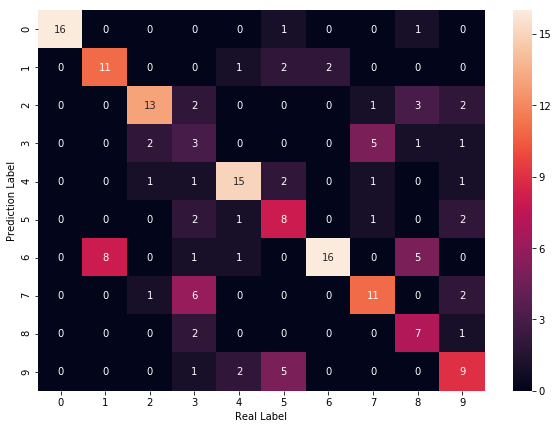

In [13]:
import seaborn as sn


df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()

In [14]:
list_P = []
for i,p_value in enumerate(pred_value):
    print("#{} min_error:{} index:{} real:{}".format(i, error_list[i], p_value[0], digits.target[1617+i]))

#0 min_error:1 index:[9] real:5
#1 min_error:2 index:[4] real:2
#2 min_error:2 index:[6 8] real:8
#3 min_error:0 index:[0] real:0
#4 min_error:1 index:[1] real:1
#5 min_error:1 index:[3 7] real:7
#6 min_error:1 index:[6] real:6
#7 min_error:0 index:[3 7] real:3
#8 min_error:0 index:[2] real:2
#9 min_error:1 index:[1] real:1
#10 min_error:0 index:[3 7] real:7
#11 min_error:1 index:[9] real:4
#12 min_error:1 index:[6] real:6
#13 min_error:2 index:[2 3 7] real:3
#14 min_error:1 index:[1] real:1
#15 min_error:1 index:[3 7] real:3
#16 min_error:1 index:[5] real:9
#17 min_error:2 index:[1 6] real:1
#18 min_error:2 index:[2 3 7] real:7
#19 min_error:1 index:[6] real:6
#20 min_error:3 index:[0 1 6 8] real:8
#21 min_error:1 index:[4] real:4
#22 min_error:1 index:[3 7] real:3
#23 min_error:1 index:[1] real:1
#24 min_error:0 index:[4] real:4
#25 min_error:0 index:[0] real:0
#26 min_error:1 index:[5] real:5
#27 min_error:0 index:[3 7] real:3
#28 min_error:2 index:[1 6] real:6
#29 min_error:1 index

In [15]:
pred_value = []
error_list = []

for j in range(1617):
    pred = []
    for i in range(10):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)
    
    error = []
    for i in range(10):
        error.append(10 - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)
    
    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )

list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
print("Testset acc:{}".format(np.sum(list_P == digits.target[:1617])/1617))
winner_fitness = []
for winner in winner_list:
    #print(winner.fitness)
    winner_fitness.append(winner.fitness)
print("Avg Base Learner:{}".format(np.mean(winner_fitness)))

Testset acc:0.6586270871985158
Avg Base Learner:0.8696351267779839


In [16]:
from random import randint

list_acc = []

for iii in range(10):
    pred_value = []
    error_list = []


    for j in range(1617,1617+180):
        pred = []
        for i in range(iii):
            [pred_outputs, real_outputs] = get_pred_real(i, j)
            #print(pred_outputs, real_outputs)
            pred.append(pred_outputs)
        #print(np.array(pred).T)

        error = []
        for i in range(10):
            error.append(iii - np.sum(number_codes[i][:iii] == np.array(pred).T))
        #print(error)

        pred_value.append(np.where(error==np.min(error)))
        error_list.append(np.min(error))
        #print(np.where(error==np.min(error)) )
    list_P = []
    for i in pred_value:
        if (len(i[0])) == 1:
            list_P.append(i[0][0])
        else:
            random_pick = randint(0, len(i[0])-1)
            list_P.append(i[0][random_pick])
    acc = np.sum(list_P == digits.target[1617:])/180
    print("Accuracy on training set: {}".format(acc))
    list_acc.append(acc)

Accuracy on training set: 0.09444444444444444
Accuracy on training set: 0.14444444444444443
Accuracy on training set: 0.19444444444444445
Accuracy on training set: 0.38333333333333336
Accuracy on training set: 0.37222222222222223
Accuracy on training set: 0.46111111111111114
Accuracy on training set: 0.48333333333333334
Accuracy on training set: 0.5444444444444444
Accuracy on training set: 0.5611111111111111
Accuracy on training set: 0.5666666666666667


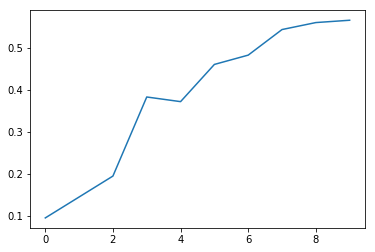

In [17]:
plt.plot(range(10),list_acc)
plt.show()

In [18]:
list_acc

[0.09444444444444444,
 0.14444444444444443,
 0.19444444444444445,
 0.38333333333333336,
 0.37222222222222223,
 0.46111111111111114,
 0.48333333333333334,
 0.5444444444444444,
 0.5611111111111111,
 0.5666666666666667]